Import Libraries and Dataset

In [5]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
# Step 2: Load your dataset
data = pd.read_csv("../data/heart.csv") 
print("Dataset shape:", data.shape)
data.head()


Dataset shape: (100, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,43,1,2,110,202,0,2,173,0,0.5,2,0,2,0
1,75,1,1,169,277,0,0,102,1,2.9,0,1,2,1
2,64,0,1,155,254,1,2,120,1,3.1,1,1,2,1
3,61,0,0,157,371,1,1,119,1,3.2,0,2,3,1
4,35,1,3,124,197,0,1,189,0,1.1,2,0,2,0


Data Cleaning & Preprocessing

In [6]:
# Step 2: Check for missing values and data types
print(data.info())
print("\nMissing values:\n", data.isnull().sum())

# If any missing values, fill or drop them
data = data.dropna()

# Check for duplicates
print("\nDuplicate rows:", data.duplicated().sum())
data = data.drop_duplicates()

# Encode categorical columns (if any)
# In the heart dataset, all columns are numeric so skip for now.
print(data.columns)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       100 non-null    int64  
 1   sex       100 non-null    int64  
 2   cp        100 non-null    int64  
 3   trestbps  100 non-null    int64  
 4   chol      100 non-null    int64  
 5   fbs       100 non-null    int64  
 6   restecg   100 non-null    int64  
 7   thalach   100 non-null    int64  
 8   exang     100 non-null    int64  
 9   oldpeak   100 non-null    float64
 10  slope     100 non-null    int64  
 11  ca        100 non-null    int64  
 12  thal      100 non-null    int64  
 13  target    100 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 11.1 KB
None

Missing values:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
d

Exploratory Data Analysis 

              age        sex         cp    trestbps        chol        fbs  \
count  100.000000  100.00000  100.00000  100.000000  100.000000  100.00000   
mean    55.090000    0.57000    1.58000  136.980000  243.780000    0.43000   
std     13.297752    0.49757    1.07478   32.454157   86.186382    0.49757   
min     31.000000    0.00000    0.00000   90.000000  120.000000    0.00000   
25%     44.000000    0.00000    1.00000  107.000000  169.000000    0.00000   
50%     53.500000    1.00000    2.00000  129.000000  214.500000    0.00000   
75%     66.000000    1.00000    2.25000  165.250000  324.250000    1.00000   
max     78.000000    1.00000    3.00000  198.000000  399.000000    1.00000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     0.950000  143.520000    0.470000    1.986000    0.890000    0.810000   
std      0.821123   42.211703    0.501614    1.431395 

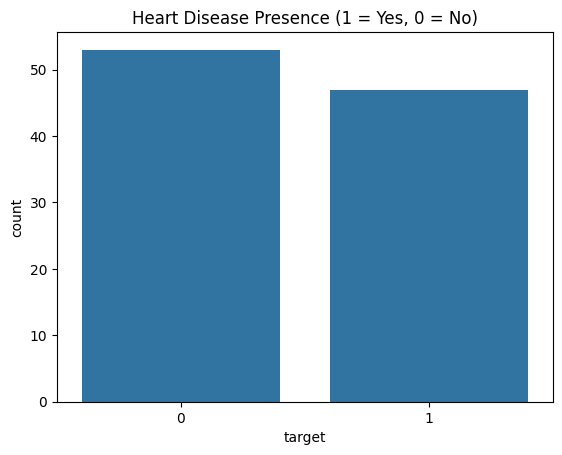

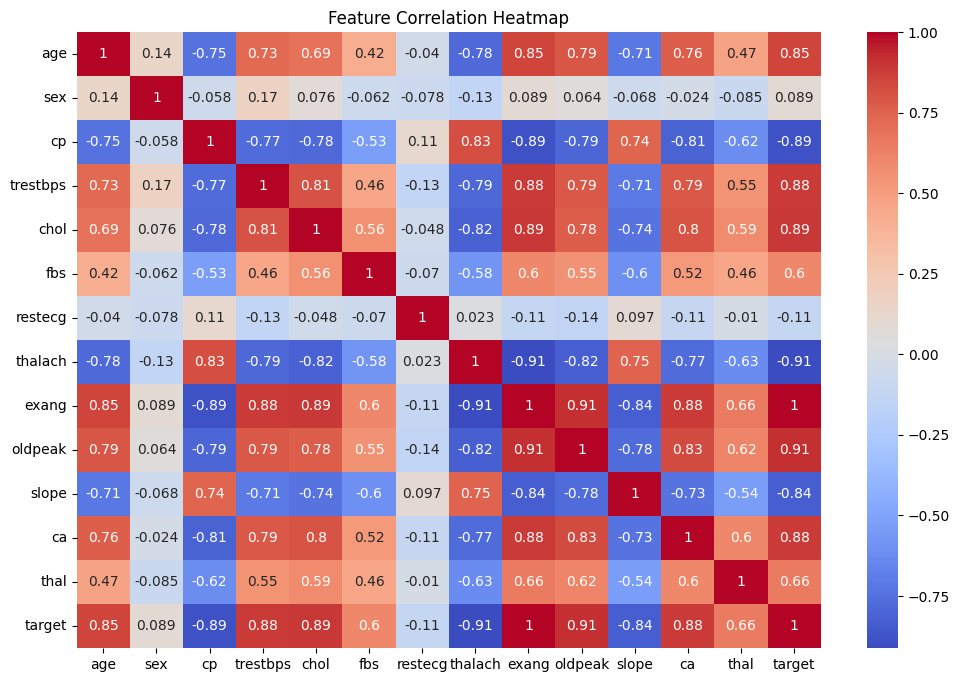

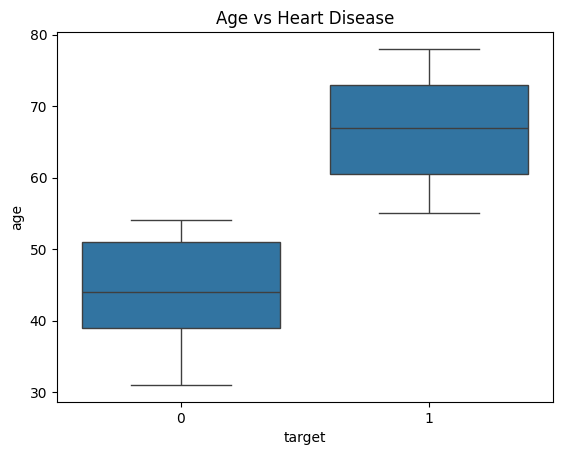

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Step 3: EDA
print(data.describe())

# Plot class distribution
sns.countplot(x='target', data=data)
plt.title("Heart Disease Presence (1 = Yes, 0 = No)")
plt.show()

# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(data.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# Check relation between age and target
sns.boxplot(x='target', y='age', data=data)
plt.title("Age vs Heart Disease")
plt.show()


Split Features & Target

In [8]:
# Step 3: Define features (X) and target (y)
X = data.drop("target", axis=1)
y = data["target"]

print("Feature shape:", X.shape)
print("Target shape:", y.shape)



Feature shape: (100, 13)
Target shape: (100,)


Encode Categorical Columns

In [9]:
# Step 4: Convert categorical columns to numeric
categorical_cols = X.select_dtypes(include=['object']).columns
encoder = LabelEncoder()

for col in categorical_cols:
    X[col] = encoder.fit_transform(X[col])


One-Hot Encode and Split

In [10]:
# Step 5: Convert to numeric dummy columns
X = pd.get_dummies(X, drop_first=True)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (80, 13)
Test size: (20, 13)


Handle Class Imbalance (SMOTE)

In [11]:
# Step 6: Balance the training data using SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print("After SMOTE balancing:")
print(y_train.value_counts())


After SMOTE balancing:
target
0    42
1    42
Name: count, dtype: int64


Scale the Data

In [12]:
# Step 7: Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Save scaler
pickle.dump(scaler, open("../models/scaler.pkl", "wb"))


Define Balanced Models

In [13]:
# Step 8: Define models with class_weight='balanced'
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced'
    ),
    "SVM": SVC(probability=True, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(
        eval_metric='logloss',
        scale_pos_weight=1,  
        random_state=42
    )
}


Train Models

In [14]:
# Step 9: Train models
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} trained successfully.")


Logistic Regression trained successfully.
Random Forest trained successfully.
SVM trained successfully.
XGBoost trained successfully.


Evaluate Models

In [15]:
# Step 10: Evaluate performance
results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred)
    }

results_df = pd.DataFrame(results).T
print("Model Performance:\n")
print(results_df)


Model Performance:

                     Accuracy  Precision  Recall  F1-Score
Logistic Regression       1.0        1.0     1.0       1.0
Random Forest             1.0        1.0     1.0       1.0
SVM                       1.0        1.0     1.0       1.0
XGBoost                   1.0        1.0     1.0       1.0


Save the Best Model

In [18]:
# Step 11: Select and save best model
best_model_name = results_df["F1-Score"].idxmax()
best_model = models[best_model_name]

print(f"\n Best Model: {best_model_name}")
print(results_df.loc[best_model_name])

# Ensure model folder exists
os.makedirs("../models", exist_ok=True)

# Save best model
with open("../models/best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print(" Best model saved successfully as '../models/best_model.pkl'")



 Best Model: Logistic Regression
Accuracy     1.0
Precision    1.0
Recall       1.0
F1-Score     1.0
Name: Logistic Regression, dtype: float64
 Best model saved successfully as '../models/best_model.pkl'


Save the Best Model

In [19]:
# Step 11: Select and save best model
best_model_name = results_df["F1-Score"].idxmax()
best_model = models[best_model_name]

print(f"\n Best Model: {best_model_name}")
print(results_df.loc[best_model_name])

# Ensure model folder exists
os.makedirs("../models", exist_ok=True)

# Save best model
with open("../models/best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("Best model saved successfully as '../models/best_model.pkl'")



 Best Model: Logistic Regression
Accuracy     1.0
Precision    1.0
Recall       1.0
F1-Score     1.0
Name: Logistic Regression, dtype: float64
Best model saved successfully as '../models/best_model.pkl'


Save Feature Columns

In [20]:
# Step 12: Save the feature column order
feature_columns = X.columns.tolist()

# Save feature columns for use in Streamlit app
with open("../models/feature_columns.pkl", "wb") as f:
    pickle.dump(feature_columns, f)

print(" Feature columns saved successfully as '../models/feature_columns.pkl'")


 Feature columns saved successfully as '../models/feature_columns.pkl'


In [21]:
# Step 11: Select and save best model
best_model_name = results_df["F1-Score"].idxmax()
best_model = models[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(results_df.loc[best_model_name])

# Ensure model folder exists
os.makedirs("../models", exist_ok=True)

# Save best model
with open("../models/best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("Best model saved successfully as '../models/best_model.pkl'")

# Step 12: Save the feature column order
feature_columns = X.columns.tolist()
with open("../models/feature_columns.pkl", "wb") as f:
    pickle.dump(feature_columns, f)

print("Feature columns saved successfully as '../models/feature_columns.pkl'")



Best Model: Logistic Regression
Accuracy     1.0
Precision    1.0
Recall       1.0
F1-Score     1.0
Name: Logistic Regression, dtype: float64
Best model saved successfully as '../models/best_model.pkl'
Feature columns saved successfully as '../models/feature_columns.pkl'
